# Предсказание вида (аспекта) сербских глаголов
## _На материалах UD_Serbian-SET_
### Импорты, настройки, глобальные переменные

In [1]:
import pandas as pd
import csv
from pathlib import Path

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.model_selection import FeatureImportances

import numpy as np

import re

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
class Log:

    cols = ["experiment_name", "model_name", "F1"]

    def __init__(self, fname: Path, sep: str):

        self.fname = fname
        self.sep = sep

        if not self.fname.exists():
            with open(fname, "w", encoding="utf-8") as file:
                file.write(self.sep.join(self.cols) + "\n")

    def write(self, vals):
        with open(self.fname, "a+", encoding="utf-8") as file:
            file.write(self.sep.join(vals) + "\n")

In [3]:
PAD_TOK = "[PAD]"
RANDOM_STATE = 42

DATAPATH = Path.cwd() / "data" / "datasetForAnalysis.csv"
LOGPATH = Path.cwd() / "data" / "models_results.csv"

SEP = "\t"

LOG = Log(LOGPATH, SEP)

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Загрузка и подготовка датасета

In [4]:
df = pd.read_csv(
    DATAPATH,
    sep="\t",
    quoting=csv.QUOTE_NONE,
    index_col=0,
    dtype=str
)

In [5]:
df = df.drop(["POS", "db_id"], axis=1)

In [6]:
df = df.fillna(PAD_TOK)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4959 entries, 0 to 4958
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   lemma          4959 non-null   object
 1   word           4959 non-null   object
 2   aspect         4959 non-null   object
 3   disambig       4959 non-null   object
 4   text           4959 non-null   object
 5   Gender         4959 non-null   object
 6   Mood           4959 non-null   object
 7   Number         4959 non-null   object
 8   Person         4959 non-null   object
 9   Tense          4959 non-null   object
 10  VerbForm       4959 non-null   object
 11  Voice          4959 non-null   object
 12  l_tok_3        4959 non-null   object
 13  l_tok_2        4959 non-null   object
 14  l_tok_1        4959 non-null   object
 15  r_tok_1        4959 non-null   object
 16  r_tok_2        4959 non-null   object
 17  r_tok_3        4959 non-null   object
 18  l_gr_1         4959 non-null   ob

In [8]:
df.nunique()

lemma             311
word             1451
aspect              3
disambig            3
text             2605
Gender              4
Mood                3
Number              3
Person              4
Tense               4
VerbForm            3
Voice               2
l_tok_3          2048
l_tok_2          2060
l_tok_1          1611
r_tok_1          1550
r_tok_2          2330
r_tok_3          2267
l_gr_1             21
l_gr_2             25
l_gr_3             28
r_gr_1              7
r_gr_2             24
r_gr_3             25
nsubj              91
nsubj_count         2
obj                54
obj_count           2
obl               141
obl_count           5
advmod             52
advmod_count        4
polarity            2
polarity_word      10
dtype: int64

In [9]:
target_vars = [
    "aspect",
    "disambig",
]

dict_vars = [
    "lemma",
    "word",
]

grapheme_vars = [
    "l_gr_1",
    "l_gr_2",
    "l_gr_3",
    "r_gr_1",
    "r_gr_2",
    "r_gr_3",
]

grammar_vars = [
    "Gender",
    "Mood",
    "Number",
    "Person",
    "Tense",
    "VerbForm",
    "Voice",
    "nsubj_count",
    "obj_count",
    "obl_count",
    "advmod_count",
    "polarity",
]

text_vars = [
    "lemma",
    "word",
    "text",
    "l_tok_3",
    "l_tok_2",
    "l_tok_1",
    "r_tok_1",
    "r_tok_2",
    "r_tok_3",
    "nsubj",
    "obj",
    "obl",
    "advmod",
    "polarity_word",
]

In [10]:
X = df.drop(target_vars, axis=1)
y = df[target_vars]

Возьмем обучающую, тестовую и валидационную выборку методом Holdout

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    shuffle=True
)

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.25,
    random_state=RANDOM_STATE,
    shuffle=True
)

In [13]:
X_train.shape, X_test.shape, X_valid.shape, y_train.shape, y_test.shape, y_valid.shape

((2975, 32), (992, 32), (992, 32), (2975, 2), (992, 2), (992, 2))

### Вспомогательные функции

In [14]:
def plot_corr(X: pd.DataFrame):

    X_cpy = X.copy(deep=True)

    label_encoder = LabelEncoder()
    for column in X_cpy.columns:
        X_cpy[column] = label_encoder.fit_transform(X_cpy[column])

    corr= X_cpy.corr()

    plt.figure(figsize=(8,6))
    sns.heatmap(
        corr,
        mask=np.abs(corr) < 0.33,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        vmin=-1,
        vmax=1
    )
    plt.title("Correlation Matrix")
    plt.show()

In [15]:
def one_hot_encode(X_train, X_test, X_valid):

    X_train_cpy = X_train.copy(deep=True)
    X_test_cpy = X_test.copy(deep=True)
    X_valid_cpy = X_valid.copy(deep=True)

    encoder = OneHotEncoder(handle_unknown='warn', sparse_output=False)

    pandas_columns = X_train_cpy.columns

    X_train_cpy = pd.DataFrame(encoder.fit_transform(X_train_cpy))
    X_test_cpy  = pd.DataFrame(encoder.transform(X_test_cpy))
    X_valid_cpy  = pd.DataFrame(encoder.transform(X_valid_cpy))

    new_columns = encoder.get_feature_names_out(pandas_columns)
    new_columns = [re.sub(r'\[|\]', '_', col) for col in new_columns]

    X_train_cpy.columns = new_columns
    X_test_cpy.columns = new_columns
    X_valid_cpy.columns = new_columns

    return X_train_cpy, X_test_cpy, X_valid_cpy

In [16]:
def experiment(experiment_name, get_model, X_train, X_test, y_train, y_test, log=LOG):

    model = get_model()
    model_name = model.__class__.__name__

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    cv_scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv=5,
        scoring="f1_weighted"
    )

    confusions = confusion_matrix(y_test, preds)
    report = classification_report(
        y_test,
        preds,
        zero_division=1.0
    )

    cv_f1 = np.mean(cv_scores)

    to_print = [
        f"\n--- {model_name} ---\n",
        f"CV F1: {cv_f1:.3f}",
        confusions,
        report
    ]

    list(
        map(lambda string: print(string, "\n"), to_print)
    )

    # viz = FeatureImportances(model, relative=False, topn=25)
    # viz.fit(X_train, y_train)
    # viz.show()

    log.write(
        [
            experiment_name,
            model_name,
            str(np.round(cv_f1, decimals=3)),
        ]
    )

### Модели

In [17]:
get_regression = lambda: LogisticRegression()
get_lgbm = lambda: LGBMClassifier(random_state=RANDOM_STATE)
get_dt = lambda: DecisionTreeClassifier(random_state=RANDOM_STATE)

In [18]:
class NNClassifier(nn.Module):

    def __init__(self, device, lr=0.001, inpt_dim=10, outpt_dim=2):
        super().__init__()
        self.device = device

        self.fc1 = nn.Linear(inpt_dim, 64)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(32, outpt_dim)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)  # logits, без активации — CrossEntropyLoss включает softmax
        return x

    def fit(self, X_train, X_valid, y_train, y_valid, num_epochs=10):

        train_loader = DataLoader(
                TensorDataset(
                torch.tensor(X_train, dtype=torch.float32),
                torch.tensor(y_train, dtype=torch.float32)
            )
        )

        val_loader = DataLoader(
            TensorDataset(
                torch.tensor(X_valid, dtype=torch.float32),
                torch.tensor(y_valid, dtype=torch.float32)
            )
        )

        for epoch in range(num_epochs):
            self.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for inputs, labels in train_loader:
                self.optimizer.zero_grad()
                outputs = self(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_loss = running_loss / total
            train_acc = correct / total

            # Валидация
            self.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for inputs, labels in val_loader:
                    outputs = self(inputs)
                    loss = self.criterion(outputs, labels)
                    val_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

            val_loss /= val_total
            val_acc = val_correct / val_total

            print(f"Epoch {epoch+1}/{num_epochs} | "
                f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


### Эксперименты графемами

In [19]:
X_train_graphemes = X_train[grapheme_vars]
X_test_graphemes = X_test[grapheme_vars]
X_valid_graphemes = X_valid[grapheme_vars]

X_train_graphemes.head()

,l_gr_1,l_gr_2,l_gr_3,r_gr_1,r_gr_2,r_gr_3
1027,k,a,ž,e,ž,a
611,i,m,a,o,m,a
2396,p,o,d,i,ć,a
4420,u,s,p,a,l,e
4274,u,k,a,a,l,a


In [20]:
X_train_graphemes_2 = X_train_graphemes.drop(["l_gr_3", "r_gr_3"], axis=1)
X_test_graphemes_2 = X_test_graphemes.drop(["l_gr_3", "r_gr_3"], axis=1)
X_valid_graphemes_2 = X_valid_graphemes.drop(["l_gr_3", "r_gr_3"], axis=1)

X_train_graphemes_2.head()

,l_gr_1,l_gr_2,r_gr_1,r_gr_2
1027,k,a,e,ž
611,i,m,o,m
2396,p,o,i,ć
4420,u,s,a,l
4274,u,k,a,l


In [21]:
X_train_graphemes_1 = X_train_graphemes_2.drop(["l_gr_2", "r_gr_2"], axis=1)
X_test_graphemes_1 = X_test_graphemes_2.drop(["l_gr_2", "r_gr_2"], axis=1)
X_valid_graphemes_1 = X_valid_graphemes_2.drop(["l_gr_2", "r_gr_2"], axis=1)

X_train_graphemes_1.head()

,l_gr_1,r_gr_1
1027,k,e
611,i,o
2396,p,i
4420,u,a
4274,u,a


In [22]:
X_train_sufs = pd.DataFrame()
X_test_sufs = pd.DataFrame()
X_valid_sufs = pd.DataFrame()

X_train_sufs["pref"] = X_train_graphemes["l_gr_1"] + X_train_graphemes["l_gr_2"] + X_train_graphemes["l_gr_3"]
X_train_sufs["suf"] = X_train_graphemes["r_gr_1"] + X_train_graphemes["r_gr_2"] + X_train_graphemes["r_gr_3"]

X_test_sufs["pref"] = X_test_graphemes["l_gr_1"] + X_test_graphemes["l_gr_2"] + X_test_graphemes["l_gr_3"]
X_test_sufs["suf"] = X_test_graphemes["r_gr_1"] + X_test_graphemes["r_gr_2"] + X_test_graphemes["r_gr_3"]

X_valid_sufs["pref"] = X_valid_graphemes["l_gr_1"] + X_valid_graphemes["l_gr_2"] + X_valid_graphemes["l_gr_3"]
X_valid_sufs["suf"] = X_valid_graphemes["r_gr_1"] + X_valid_graphemes["r_gr_2"] + X_valid_graphemes["r_gr_3"]

X_train_sufs.head()

,pref,suf
1027,kaž,eža
611,ima,oma
2396,pod,ića
4420,usp,ale
4274,uka,ala


In [23]:
X_train_sufs.nunique()

pref    211
suf     243
dtype: int64

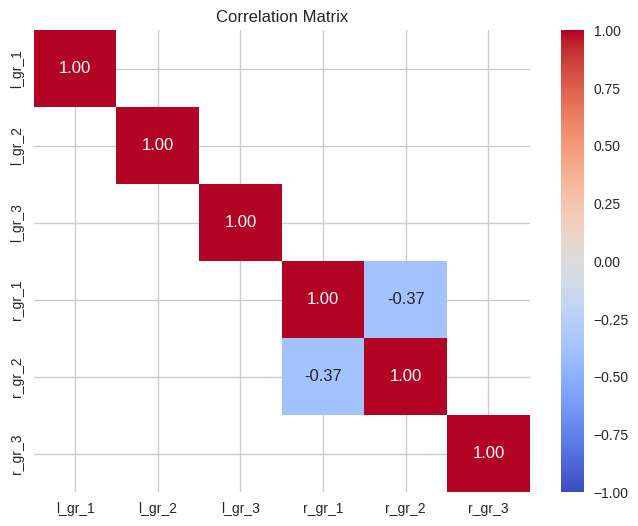

In [24]:
plot_corr(X_train_graphemes)

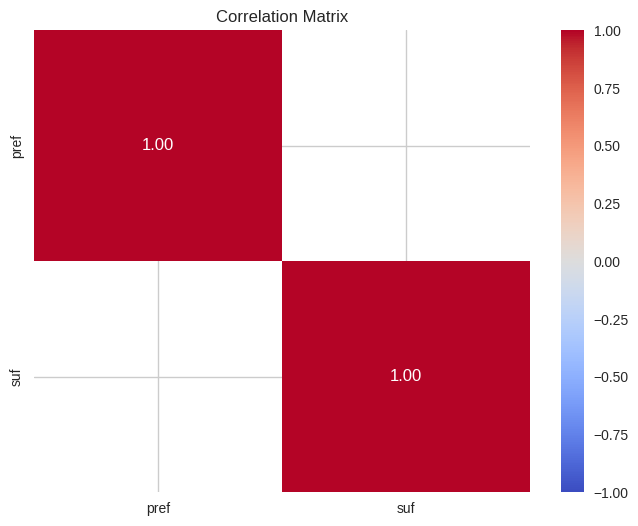

In [25]:
plot_corr(X_train_sufs)

In [26]:
X_train_graphemes, X_test_graphemes, X_valid_graphemes = one_hot_encode(
    X_train_graphemes,
    X_test_graphemes,
    X_valid_graphemes,
)

In [27]:
X_train_graphemes.shape, X_test_graphemes.shape, X_valid_graphemes.shape

((2975, 127), (992, 127), (992, 127))

In [28]:
X_train_sufs, X_test_sufs, X_valid_sufs = one_hot_encode(
    X_train_sufs,
    X_test_sufs,
    X_valid_sufs,
)

In [29]:
X_train_sufs.shape, X_test_sufs.shape, X_valid_sufs.shape

((2975, 454), (992, 454), (992, 454))

In [30]:
X_train_graphemes_2, X_test_graphemes_2, X_valid_graphemes_2 = one_hot_encode(
    X_train_graphemes_2,
    X_test_graphemes_2,
    X_valid_graphemes_2,
)

In [31]:
X_train_graphemes_1, X_test_graphemes_1, X_valid_graphemes_1 = one_hot_encode(
    X_train_graphemes_1,
    X_test_graphemes_1,
    X_valid_graphemes_1,
)

In [32]:
experiment(
    "all_graphemes",
    lambda: LogisticRegression(),
    X_train_graphemes,
    X_test_graphemes,
    y_train["aspect"],
    y_test["aspect"]
)


--- LogisticRegression ---
 

CV F1: 0.882 

[[ 32   5   4]
 [  0 404  62]
 [  0  47 438]] 

              precision    recall  f1-score   support

        both       1.00      0.78      0.88        41
         imp       0.89      0.87      0.88       466
        perf       0.87      0.90      0.89       485

    accuracy                           0.88       992
   macro avg       0.92      0.85      0.88       992
weighted avg       0.88      0.88      0.88       992
 



In [33]:
experiment(
    "all_graphemes",
    lambda: LGBMClassifier(verbose=-1),
    X_train_graphemes,
    X_test_graphemes,
    y_train["aspect"],
    y_test["aspect"]
)


--- LGBMClassifier ---
 

CV F1: 0.958 

[[ 41   0   0]
 [  0 443  23]
 [  0  10 475]] 

              precision    recall  f1-score   support

        both       1.00      1.00      1.00        41
         imp       0.98      0.95      0.96       466
        perf       0.95      0.98      0.97       485

    accuracy                           0.97       992
   macro avg       0.98      0.98      0.98       992
weighted avg       0.97      0.97      0.97       992
 



In [34]:
experiment(
    "all_graphemes",
    lambda: DecisionTreeClassifier(random_state=RANDOM_STATE),
    X_train_graphemes,
    X_test_graphemes,
    y_train["aspect"],
    y_test["aspect"]
)


--- DecisionTreeClassifier ---
 

CV F1: 0.929 

[[ 41   0   0]
 [  0 435  31]
 [  0  22 463]] 

              precision    recall  f1-score   support

        both       1.00      1.00      1.00        41
         imp       0.95      0.93      0.94       466
        perf       0.94      0.95      0.95       485

    accuracy                           0.95       992
   macro avg       0.96      0.96      0.96       992
weighted avg       0.95      0.95      0.95       992
 



In [35]:
experiment(
    "sufs",
    lambda: LogisticRegression(),
    X_train_sufs,
    X_test_sufs,
    y_train["aspect"],
    y_test["aspect"]
)


--- LogisticRegression ---
 

CV F1: 0.939 

[[ 37   3   1]
 [  0 435  31]
 [  0  18 467]] 

              precision    recall  f1-score   support

        both       1.00      0.90      0.95        41
         imp       0.95      0.93      0.94       466
        perf       0.94      0.96      0.95       485

    accuracy                           0.95       992
   macro avg       0.96      0.93      0.95       992
weighted avg       0.95      0.95      0.95       992
 



In [36]:
experiment(
    "sufs",
    lambda: LGBMClassifier(random_state=RANDOM_STATE),
    X_train_sufs,
    X_test_sufs,
    y_train["aspect"],
    y_test["aspect"]
)


--- LGBMClassifier ---
 

CV F1: 0.753 

[[ 30   6   5]
 [  0 278 188]
 [  0  32 453]] 

              precision    recall  f1-score   support

        both       1.00      0.73      0.85        41
         imp       0.88      0.60      0.71       466
        perf       0.70      0.93      0.80       485

    accuracy                           0.77       992
   macro avg       0.86      0.75      0.79       992
weighted avg       0.80      0.77      0.76       992
 



In [37]:
experiment(
    "sufs",
    lambda: DecisionTreeClassifier(random_state=RANDOM_STATE),
    X_train_sufs,
    X_test_sufs,
    y_train["aspect"],
    y_test["aspect"]
)


--- DecisionTreeClassifier ---
 

CV F1: 0.950 

[[ 39   2   0]
 [  0 439  27]
 [  0  20 465]] 

              precision    recall  f1-score   support

        both       1.00      0.95      0.97        41
         imp       0.95      0.94      0.95       466
        perf       0.95      0.96      0.95       485

    accuracy                           0.95       992
   macro avg       0.97      0.95      0.96       992
weighted avg       0.95      0.95      0.95       992
 



In [38]:
experiment(
    "2_graphemes",
    lambda: LogisticRegression(),
    X_train_graphemes_2,
    X_test_graphemes_2,
    y_train["aspect"],
    y_test["aspect"]
)


--- LogisticRegression ---
 

CV F1: 0.856 

[[ 33   4   4]
 [  0 392  74]
 [  1  58 426]] 

              precision    recall  f1-score   support

        both       0.97      0.80      0.88        41
         imp       0.86      0.84      0.85       466
        perf       0.85      0.88      0.86       485

    accuracy                           0.86       992
   macro avg       0.89      0.84      0.86       992
weighted avg       0.86      0.86      0.86       992
 



In [39]:
experiment(
    "2_graphemes",
    lambda: LGBMClassifier(random_state=RANDOM_STATE),
    X_train_graphemes_2,
    X_test_graphemes_2,
    y_train["aspect"],
    y_test["aspect"]
)


--- LGBMClassifier ---
 

CV F1: 0.904 

[[ 40   1   0]
 [  0 420  46]
 [  1  33 451]] 

              precision    recall  f1-score   support

        both       0.98      0.98      0.98        41
         imp       0.93      0.90      0.91       466
        perf       0.91      0.93      0.92       485

    accuracy                           0.92       992
   macro avg       0.94      0.94      0.94       992
weighted avg       0.92      0.92      0.92       992
 



In [40]:
experiment(
    "2_graphemes",
    lambda: DecisionTreeClassifier(random_state=RANDOM_STATE),
    X_train_graphemes_2,
    X_test_graphemes_2,
    y_train["aspect"],
    y_test["aspect"]
)


--- DecisionTreeClassifier ---
 

CV F1: 0.892 

[[ 40   1   0]
 [  0 420  46]
 [  1  30 454]] 

              precision    recall  f1-score   support

        both       0.98      0.98      0.98        41
         imp       0.93      0.90      0.92       466
        perf       0.91      0.94      0.92       485

    accuracy                           0.92       992
   macro avg       0.94      0.94      0.94       992
weighted avg       0.92      0.92      0.92       992
 



In [41]:
experiment(
    "1_grapheme",
    lambda: LogisticRegression(),
    X_train_graphemes_1,
    X_test_graphemes_1,
    y_train["aspect"],
    y_test["aspect"]
)


--- LogisticRegression ---
 

CV F1: 0.731 

[[ 32   4   5]
 [  8 292 166]
 [  3  78 404]] 

              precision    recall  f1-score   support

        both       0.74      0.78      0.76        41
         imp       0.78      0.63      0.70       466
        perf       0.70      0.83      0.76       485

    accuracy                           0.73       992
   macro avg       0.74      0.75      0.74       992
weighted avg       0.74      0.73      0.73       992
 



In [42]:
experiment(
    "1_grapheme",
    lambda: LGBMClassifier(random_state=RANDOM_STATE),
    X_train_graphemes_1,
    X_test_graphemes_1,
    y_train["aspect"],
    y_test["aspect"]
)


--- LGBMClassifier ---
 

CV F1: 0.732 

[[ 32   4   5]
 [  3 325 138]
 [  0 110 375]] 

              precision    recall  f1-score   support

        both       0.91      0.78      0.84        41
         imp       0.74      0.70      0.72       466
        perf       0.72      0.77      0.75       485

    accuracy                           0.74       992
   macro avg       0.79      0.75      0.77       992
weighted avg       0.74      0.74      0.74       992
 



In [43]:
experiment(
    "1_grapheme",
    lambda: DecisionTreeClassifier(random_state=RANDOM_STATE),
    X_train_graphemes_1,
    X_test_graphemes_1,
    y_train["aspect"],
    y_test["aspect"]
)


--- DecisionTreeClassifier ---
 

CV F1: 0.732 

[[ 32   4   5]
 [  3 325 138]
 [  0 108 377]] 

              precision    recall  f1-score   support

        both       0.91      0.78      0.84        41
         imp       0.74      0.70      0.72       466
        perf       0.72      0.78      0.75       485

    accuracy                           0.74       992
   macro avg       0.79      0.75      0.77       992
weighted avg       0.74      0.74      0.74       992
 



In [44]:
y_onehot = one_hot_encode(
    y_train[["aspect"]],
    y_test[["aspect"]],
    y_valid[["aspect"]]
)

In [45]:
m = NNClassifier("cuda", inpt_dim=X_train_graphemes.shape[1], outpt_dim=y_onehot[0].shape[1])

In [ ]:
m.fit(
    X_train_graphemes.to_numpy(dtype=np.int8),
    X_valid_graphemes.to_numpy(dtype=np.int8),
   y_onehot[0].to_numpy(dtype=np.int8),
   y_onehot[-1].to_numpy(dtype=np.int8),
   num_epochs=6
)

Epoch 1/10 | Train Loss: 0.4625, Train Acc: 0.4968 | Val Loss: 0.2963, Val Acc: 0.4819
Epoch 2/10 | Train Loss: 0.2586, Train Acc: 0.5170 | Val Loss: 0.2227, Val Acc: 0.5212
Epoch 3/10 | Train Loss: 0.1946, Train Acc: 0.5244 | Val Loss: 0.1972, Val Acc: 0.5302
Epoch 4/10 | Train Loss: 0.1585, Train Acc: 0.5308 | Val Loss: 0.1825, Val Acc: 0.5514
Epoch 5/10 | Train Loss: 0.1327, Train Acc: 0.5281 | Val Loss: 0.1755, Val Acc: 0.5655
Epoch 6/10 | Train Loss: 0.1158, Train Acc: 0.5338 | Val Loss: 0.1710, Val Acc: 0.5534
Epoch 7/10 | Train Loss: 0.1023, Train Acc: 0.5308 | Val Loss: 0.1752, Val Acc: 0.5665
Epoch 8/10 | Train Loss: 0.0906, Train Acc: 0.5321 | Val Loss: 0.1830, Val Acc: 0.5766
Epoch 9/10 | Train Loss: 0.0876, Train Acc: 0.5358 | Val Loss: 0.1932, Val Acc: 0.5726
Epoch 10/10 | Train Loss: 0.0733, Train Acc: 0.5365 | Val Loss: 0.2012, Val Acc: 0.5726


In [ ]:
def experiment(experiment_name, get_model, X_train, X_test, y_train, y_test, log=LOG):

    model = get_model()
    model_name = model.__class__.__name__

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    cv_scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv=5,
        scoring="f1_weighted"
    )

    confusions = confusion_matrix(y_test, preds)
    report = classification_report(
        y_test,
        preds,
        zero_division=1.0
    )

    cv_f1 = np.mean(cv_scores)

    to_print = [
        f"\n--- {model_name} ---\n",
        f"CV F1: {cv_f1:.3f}",
        confusions,
        report
    ]

    list(
        map(lambda string: print(string, "\n"), to_print)
    )

    # viz = FeatureImportances(model, relative=False, topn=25)
    # viz.fit(X_train, y_train)
    # viz.show()

    log.write(
        [
            experiment_name,
            model_name,
            str(np.round(cv_f1, decimals=3)),
        ]
    )